# Polymarket Momentum Analysis

This notebook uses the `data/collect_polymarket.py` outputs to explore four questions:
1. Which markets are informational vs trivial?
2. Where does belief change precede resolution?
3. Who moves prices first?
4. When does momentum become noise?

Notes:
- This analysis uses token price history as a proxy for belief.
- PnL is proxied with early vs late price changes because trade-level data is not in the collector output.


In [285]:
from pathlib import Path
import json
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

DATA_DIR = Path('../../data')
PM_DIR = DATA_DIR / 'polymarket'
MARKETS_JSONL = PM_DIR / 'markets.jsonl'
PRICES_JSONL = PM_DIR / 'prices_history.jsonl'
MARKETS_CSV = DATA_DIR / 'polymarket_data' / 'markets.csv'

# Analysis parameters
MIN_POINTS = 9
EARLY_FRAC = 0.1
LATE_FRAC = 0.1
VELOCITY_DAYS = 7


In [286]:
def load_markets():
    if MARKETS_JSONL.exists():
        rows = []
        with MARKETS_JSONL.open('r', encoding='utf-8') as f:
            for line in f:
                if line.strip():
                    rows.append(json.loads(line))
        return pd.DataFrame(rows)
    if MARKETS_CSV.exists():
        return pd.read_csv(MARKETS_CSV)
    raise FileNotFoundError('No markets data found.')

def _expand_history(row):
    hist = row.get('history')
    if hist is None:
        return []
    points = []
    # handle list of dicts or list of lists
    for item in hist:
        if isinstance(item, dict):
            t = item.get('t')
            p = item.get('p')
        elif isinstance(item, (list, tuple)) and len(item) >= 2:
            t, p = item[0], item[1]
        else:
            continue
        points.append((t, p))
    return points

def _first_token_map(markets_df):
    if markets_df is None or markets_df.empty:
        return {}
    key_col = 'market_id' if 'market_id' in markets_df.columns else None
    if key_col is None and 'id' in markets_df.columns:
        key_col = 'id'
    if key_col is None:
        return {}
    token_map = {}
    for _, row in markets_df.iterrows():
        tokens = row.get('clobTokenIds')
        if isinstance(tokens, str):
            try:
                tokens = json.loads(tokens)
            except json.JSONDecodeError:
                tokens = None
        if isinstance(tokens, list) and tokens:
            token_map[str(row.get(key_col))] = str(tokens[0])
    return token_map

def load_prices(markets_df):
    token_map = _first_token_map(markets_df)
    rows = []
    with PRICES_JSONL.open('r', encoding='utf-8') as f:
        for line in f:
            if not line.strip():
                continue
            row = json.loads(line)
            m_id = row.get('market_id')
            if m_id is None:
                continue
            yes_token = token_map.get(str(m_id))
            if yes_token is None:
                continue
            if str(row.get('token_id')) != str(yes_token):
                continue
            rows.append(row)
    return rows


In [287]:
markets_df = load_markets()
price_rows = load_prices(markets_df)

print('Markets:', len(markets_df))
print('Price rows:', len(price_rows))


Markets: 1000
Price rows: 1000


In [288]:
expanded = []
for row in price_rows:
    cid = row.get('conditionId')
    token_id = row.get('token_id')
    m_id = row.get('market_id')
    for t, p in _expand_history(row):
        if t is None or p is None:
            continue
        expanded.append({
            'conditionId': cid,
            'market_id': m_id,
            'token_id': token_id,
            'timestamp': pd.to_datetime(t, unit='s', utc=True, errors='coerce'),
            'price': float(p),
        })

prices_df = pd.DataFrame(expanded)
prices_df = prices_df.dropna(subset=['timestamp'])
prices_df = prices_df.sort_values(['token_id', 'timestamp'])

prices_df.head()


,conditionId,market_id,token_id,timestamp,price
19085,0x92f5d3c973225f097d4ed6a3416fb4dd6e6b28f2a0ee...,573261,1000020818850347647642138982815862649491064470...,2025-08-07 00:00:06+00:00,0.710
19086,0x92f5d3c973225f097d4ed6a3416fb4dd6e6b28f2a0ee...,573261,1000020818850347647642138982815862649491064470...,2025-08-07 12:00:07+00:00,0.625
19087,0x92f5d3c973225f097d4ed6a3416fb4dd6e6b28f2a0ee...,573261,1000020818850347647642138982815862649491064470...,2025-08-08 00:00:02+00:00,0.305
19088,0x92f5d3c973225f097d4ed6a3416fb4dd6e6b28f2a0ee...,573261,1000020818850347647642138982815862649491064470...,2025-08-08 12:00:18+00:00,0.305
19089,0x92f5d3c973225f097d4ed6a3416fb4dd6e6b28f2a0ee...,573261,1000020818850347647642138982815862649491064470...,2025-08-09 00:00:05+00:00,0.315


## Feature engineering
We compute per-token metrics:
- Mean entropy of the price series
- Flip frequency across 0.5
- Belief velocity in the final window before resolution
- Early vs late PnL proxy (price change to final)
- Momentum autocorrelation and predictive power


In [289]:
def entropy(p):
    p = np.clip(p, 1e-6, 1 - 1e-6)
    return -(p * np.log(p) + (1 - p) * np.log(1 - p))

def flip_frequency(series):
    if len(series) < 2:
        return 0
    signs = np.sign(series - 0.5)
    # count sign changes ignoring zeros
    flips = 0
    prev = None
    for s in signs:
        if s == 0:
            continue
        if prev is not None and s != prev:
            flips += 1
        prev = s
    return flips

def belief_velocity(ts, prices, resolution_time):
    if len(prices) < 2:
        return np.nan
    if resolution_time is None:
        window_end = ts.iloc[-1]
    else:
        window_end = resolution_time
    window_start = window_end - pd.Timedelta(days=VELOCITY_DAYS)
    mask = (ts >= window_start) & (ts <= window_end)
    sub = prices[mask]
    if len(sub) < 2:
        return np.nan
    return np.mean(np.abs(np.diff(sub)))

def early_late_pnl(prices):
    if len(prices) < 2:
        return np.nan, np.nan
    n = len(prices)
    early_n = max(1, int(n * EARLY_FRAC))
    late_n = max(1, int(n * LATE_FRAC))
    early_price = np.mean(prices[:early_n])
    late_price = np.mean(prices[-late_n:])
    final_price = prices[-1]
    return abs(final_price - early_price), abs(final_price - late_price)

def momentum_metrics(prices, horizon=5):
    if len(prices) < max(3, horizon + 2):
        return np.nan, np.nan
    returns = np.diff(prices)
    if np.std(returns) == 0:
        return 0.0, 0.0
    autocorr = np.corrcoef(returns[:-1], returns[1:])[0, 1]
    # predictive power: correlation of last return with future h-step price change
    future_change = prices[horizon:] - prices[:-horizon]
    aligned = returns[: len(future_change)]
    if len(aligned) < 2:
        return autocorr, np.nan
    pred = np.corrcoef(aligned, future_change)[0, 1]
    return autocorr, pred

def get_resolution_time(markets_df, cid):
    if markets_df is None or markets_df.empty:
        return None
    rows = markets_df[markets_df.get('conditionId', markets_df.get('condition_id')) == cid]
    if rows.empty:
        return None
    for col in ['closedTime', 'endDate', 'endDateIso']:
        if col in rows.columns:
            val = rows.iloc[0].get(col)
            if pd.notna(val):
                return pd.to_datetime(val, utc=True, errors='coerce')
    return None

def _question_map(df):
    if df is None or df.empty:
        return {}
    q_col = 'question' if 'question' in df.columns else None
    if q_col is None:
        return {}
    if 'conditionId' in df.columns:
        cid_col = 'conditionId'
    elif 'condition_id' in df.columns:
        cid_col = 'condition_id'
    else:
        cid_col = None
    mapping = {}
    if cid_col:
        mapping.update(dict(zip(df[cid_col].astype(str), df[q_col])))
    if 'market_id' in df.columns:
        mapping.update(dict(zip(df['market_id'].astype(str), df[q_col])))
    if 'id' in df.columns:
        mapping.update(dict(zip(df['id'].astype(str), df[q_col])))
    return mapping


In [290]:
token_groups = prices_df.groupby('token_id')
rows = []

for token_id, g in token_groups:
    g = g.sort_values('timestamp')
    prices = g['price'].to_numpy()
    if len(prices) < MIN_POINTS:
        continue
    cid = g['conditionId'].iloc[0]
    resolution_time = get_resolution_time(markets_df, cid)
    mean_entropy = float(np.mean(entropy(prices)))
    flips = int(flip_frequency(prices))
    velocity = belief_velocity(g['timestamp'], prices, resolution_time)
    early_pnl, late_pnl = early_late_pnl(prices)
    autocorr, pred = momentum_metrics(prices)
    rows.append({
        'token_id': token_id,
        'conditionId': cid,
        'market_id': g['market_id'].iloc[0],
        'points': len(prices),
        'mean_entropy': mean_entropy,
        'flip_count': flips,
        'velocity': velocity,
        'early_pnl_proxy': early_pnl,
        'late_pnl_proxy': late_pnl,
        'autocorr': autocorr,
        'pred_power': pred,
        'final_price': prices[-1],
    })

metrics = pd.DataFrame(rows)
question_map = _question_map(markets_df)
metrics['question'] = metrics['conditionId'].astype(str).map(question_map)
metrics.loc[metrics['question'].isna(), 'question'] = metrics['market_id'].astype(str).map(question_map)
metrics.head()


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


,token_id,conditionId,market_id,points,mean_entropy,flip_count,velocity,early_pnl_proxy,late_pnl_proxy,autocorr,pred_power,final_price,question
0,1000020818850347647642138982815862649491064470...,0x92f5d3c973225f097d4ed6a3416fb4dd6e6b28f2a0ee...,573261,51,0.448093,3,0.016571,0.4460,0.01130,-0.039893,0.469583,0.0060,Trump imposes tariff on pharmaceuticals by Aug...
1,1000408696515732713314844979522457272267766060...,0x07094b57090c2c10fd47fed6a9f7f18b7692fd617b90...,548874,21,0.605537,1,0.054964,0.5970,0.24725,-0.181457,0.543004,0.9945,Verstappen vs. Piastri
2,1003364619577675634390461213449721484917439262...,0x0a6073ae63c651f666d1596c160582d8139d75904c4e...,583231,8,0.693141,0,0.000714,0.0050,0.00000,NaN,NaN,0.4950,"Solana Up or Down - September 2, 11AM ET"
3,1004281994946283372952593213240460956568379878...,0xdb4c9be8df4f83ccfce2c59e6aa17357324a0bead6b4...,596148,28,0.659633,0,0.039962,0.4970,0.19225,0.172831,0.054986,0.0005,Will Girona win on 2025-09-26?
4,1005894740092472785494414890184153172024685323...,0x00cba2a437e0cb3c5d3fca0c4bf920104efca53e2382...,616761,14,0.564635,2,0.122731,0.3395,0.00000,0.046610,0.080067,0.0005,Will XRP reach $3.10 September 29-October 5?


## Visuals
Quick plots to sanity-check distributions and relationships.


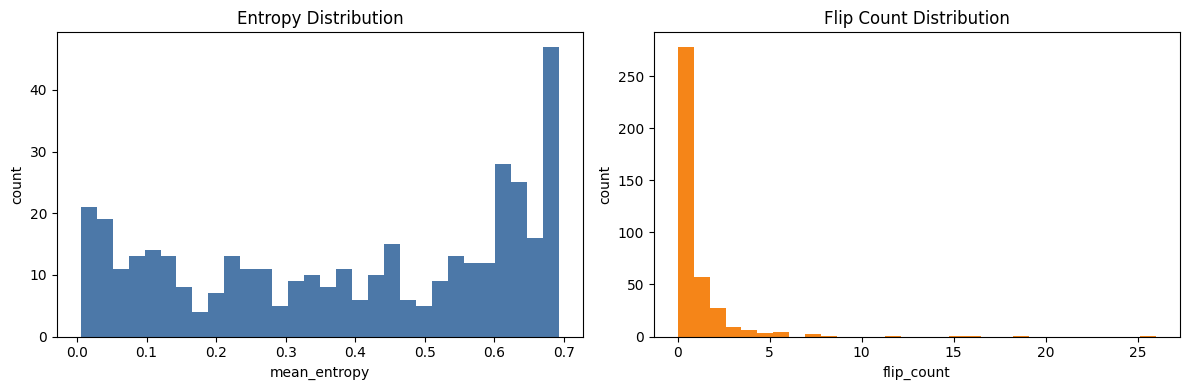

In [291]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(metrics['mean_entropy'].dropna(), bins=30, color='#4c78a8')
axes[0].set_title('Entropy Distribution')
axes[0].set_xlabel('mean_entropy')
axes[0].set_ylabel('count')

axes[1].hist(metrics['flip_count'].dropna(), bins=30, color='#f58518')
axes[1].set_title('Flip Count Distribution')
axes[1].set_xlabel('flip_count')
axes[1].set_ylabel('count')

plt.tight_layout()


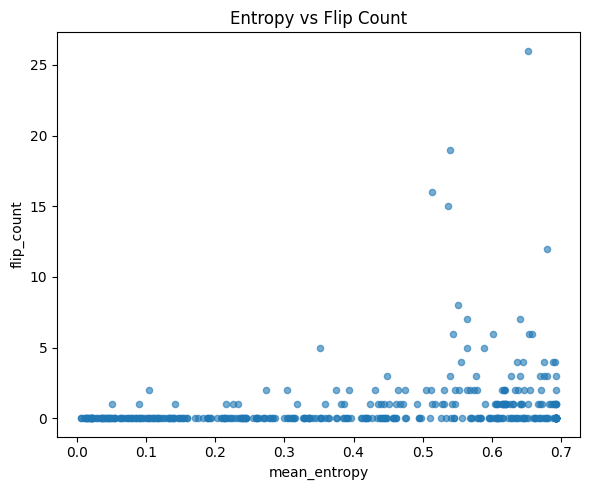

In [292]:
plt.figure(figsize=(6, 5))
plt.scatter(metrics['mean_entropy'], metrics['flip_count'], s=20, alpha=0.6)
plt.title('Entropy vs Flip Count')
plt.xlabel('mean_entropy')
plt.ylabel('flip_count')
plt.tight_layout()


## 1) Informational vs trivial markets
- Low entropy implies near-certain outcomes (trivial).
- High entropy + high flip frequency implies informational (beliefs shifting).


In [293]:
entropy_q = metrics['mean_entropy'].quantile([0.25, 0.75]).to_dict()
flip_q = metrics['flip_count'].quantile([0.25, 0.75]).to_dict()

def classify(row):
    if row['mean_entropy'] <= entropy_q[0.25] and row['flip_count'] <= flip_q[0.25]:
        return 'trivial'
    if row['mean_entropy'] >= entropy_q[0.75] and row['flip_count'] >= flip_q[0.75]:
        return 'informational'
    return 'mixed'

metrics['info_class'] = metrics.apply(classify, axis=1)

metrics['info_class'].value_counts()


mixed            249
trivial           94
informational     49
Name: info_class, dtype: int64

In [294]:
metrics.sort_values(['info_class', 'mean_entropy'], ascending=[True, True]) [['info_class', 'question', 'conditionId', 'mean_entropy', 'flip_count']].head(10)


,info_class,question,conditionId,mean_entropy,flip_count
106,informational,Will Alabama make the College Football Playoff?,0x8a1c1646502d93b9ecb5420c0cf99f893d6b5f3228c8...,0.617495,2
185,informational,Knicks vs. Pistons,0x5626a8fdffcd2db7c93fc3039f0e21a4b641e222fe19...,0.618143,1
120,informational,Will Gambia vs. Burundi end in a draw?,0xddc33977bf38b9a64b418286e3d77f685ac69bb1dd49...,0.618156,2
286,informational,Will the Thunder beat the Nuggets 4-2?,0xac994470251def22c21f59cbf56903571f0fbe79a85d...,0.618266,1
238,informational,Bruins vs. Lightning,0x986696e130923e1a464dc891f03e855d27f1d2af7fc6...,0.618339,1
295,informational,Washington vs. Penn State,0x7047980158aff6bd520c7ce54fa56ac3d8bdb75e83bb...,0.618457,2
15,informational,Will the highest temperature in London be betw...,0xb9a40e13d58cddf036f468630ca41e254aaa7a1c7161...,0.619802,1
379,informational,"Will Trump say ""Gold Card"" this week?",0x87af4700bc0a71fd07178b4407d5a17070a4486289c4...,0.620256,1
71,informational,Geoff Neal vs. Carlos Prates,0x123b3f72abba3f6e8c3fed5e7a47dce9cf687703d25a...,0.620956,1
341,informational,"Will Kendrick Lamar perform ""m.A.A.d. City""?",0xb5dae812701a0f9555a7dd02b4e3be4475fdcba57080...,0.626172,1


## 2) Belief change precedes resolution
We look for high belief velocity in the final window before resolution.


In [295]:
metrics[['question', 'conditionId', 'token_id', 'velocity']].sort_values('velocity', ascending=False).head(10)


,question,conditionId,token_id,velocity
55,Will Alejandro Davidovich Fokina win the 2025 ...,0x3de2d96e32cd568c06025655ccd9141b573ed35eb8b1...,1119513334706046071697438279911226859150139945...,0.178708
368,"Ethereum above $2,300 on March 7?",0xc3e94e2db4052a7e49f9c3edbcc1119664ce565c4062...,9293037960770603328372159781440253969870948811...,0.152692
239,Will the price of Solana be between $190 and $...,0x32bf36835891cc8a262da936a8fb0c76e90b2a92c10a...,5624884208680820531027679622461960374352774083...,0.146038
134,Will Jeffrey Randall Allen (Player 831) win th...,0x231e2a6bf0faf0dd49767271c58091559a3a105fe65d...,3044650094485599142579911370487421943054954520...,0.143179
161,Trump posts 20-29 times on X?,0x9c99707eb18ef1fcc485fbee4f9cf7c7e3de28af153f...,3550546791102660881686083996504336082793553955...,0.140500
211,Will Microsoft be the largest company in the w...,0xa6658afc37e5479fdf54f6a43c2fce50c9acc72aae97...,4763079819192451681851302967268165202797295999...,0.128308
4,Will XRP reach $3.10 September 29-October 5?,0x00cba2a437e0cb3c5d3fca0c4bf920104efca53e2382...,1005894740092472785494414890184153172024685323...,0.122731
200,XRP above $2.10 on June 6?,0x900df5c1b5aefa66001aec72a2b86ecd8a7129b331b1...,4480215840340975770335786652382338431905535189...,0.121538
126,Will Robert Shwartzman win the Chevrolet Detro...,0x75a1964e02b8e992021a8d590b81603577d5c0c88b8d...,2766247865069046691491728669899563603080206694...,0.117500
15,Will the highest temperature in London be betw...,0xb9a40e13d58cddf036f468630ca41e254aaa7a1c7161...,1025050546454904257503671600891996553420016828...,0.116429


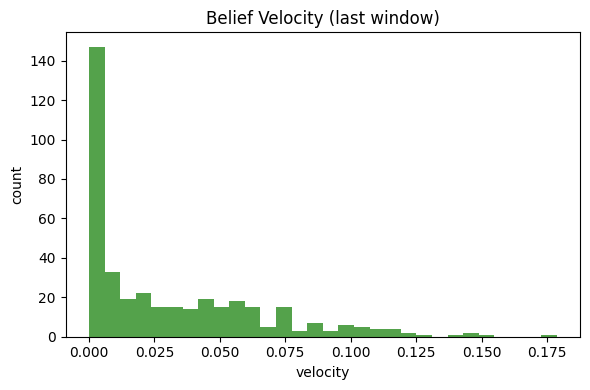

In [296]:
plt.figure(figsize=(6, 4))
plt.hist(metrics['velocity'].dropna(), bins=30, color='#54a24b')
plt.title('Belief Velocity (last window)')
plt.xlabel('velocity')
plt.ylabel('count')
plt.tight_layout()


## 3) Who moves prices first?
We compare early vs late PnL proxies. Higher early PnL suggests earlier information advantage.


In [297]:
metrics['early_vs_late'] = metrics['early_pnl_proxy'] - metrics['late_pnl_proxy']
metrics[['question', 'conditionId', 'token_id', 'early_pnl_proxy', 'late_pnl_proxy', 'early_vs_late']].sort_values('early_vs_late', ascending=False).head(10)


,question,conditionId,token_id,early_pnl_proxy,late_pnl_proxy,early_vs_late
360,Taylor Swift shown on the Super Bowl LIX broad...,0xae8a6b3a3b6ab6342aec595fd2e19acb59f2662415d2...,9059370479986658064682166128015300940944631257...,0.919500,0.004000,0.915500
27,Houthi strike on Israel by August 31?,0x89f0c865380f678336c390ddc4fe63bd14b77852d8b8...,1044226281670089367613699870376442906161322702...,0.781833,0.000250,0.781583
164,Another Elon baby before July?,0x3e2976ea24b1afddd8ecd8e0a186ff1b42b9fb2655f5...,3612354517919367389121596135132184486548692805...,0.855500,0.117750,0.737750
346,Will Cursor support Grok-3 before April?,0xdd9785916a85123520fe8f41cf6f72e7dc23c04f5f4a...,8715111472377763348351053549272138883503479896...,0.798187,0.073563,0.724625
60,Will Denmark beat Portugal?,0xde4a248f190427d7c260ccfc62eeba7b339539b0f566...,1129045509850872018359475611120204203106622862...,0.724500,0.000000,0.724500
262,"Will the price of Ethereum be above $4,500 on ...",0xabea205e1e2e18bafae5ee1c47d97ee180f87ee087c9...,6215191018366917400162472639557619256051186158...,0.697000,0.000000,0.697000
383,Will Shane Van Gisbergen win the 2025 NASCAR G...,0x26c06323b97f17a3da42c51728f02b15b37c51ce3df8...,9755078279123800977604789044358248441706726136...,0.687500,0.000000,0.687500
74,Will Ethereum reach $3100 in July?,0xb857c3afae5fd6d6d51414879f3d186b633347cadc4c...,1175672724183705269451643975092173901647571159...,0.827833,0.143000,0.684833
386,Will Trump win Iowa by 12+ points?,0x8c17e231fe93db614c7d1ab56121b0f987a0d69b798f...,9800598691772157582898005283544224625048852302...,0.684143,0.006071,0.678071
385,Will inflation reach more than 3% in 2025?,0x66dc31c8bae61b2bf31a7dae377618ebf1669ef58b26...,9775126640867662851557222965781927345490506332...,0.728132,0.055162,0.672971


## 4) When does momentum become noise?
Noise-like momentum: high autocorrelation with low predictive power or mean-reverting returns.


In [298]:
noise_candidates = metrics.copy()
noise_candidates['noise_score'] = noise_candidates['autocorr'] - noise_candidates['pred_power']
noise_candidates = noise_candidates.sort_values('noise_score', ascending=False)
noise_candidates[['question', 'conditionId', 'token_id', 'autocorr', 'pred_power', 'noise_score']].head(10)


,question,conditionId,token_id,autocorr,pred_power,noise_score
336,MLS: Will Nashville beat NYCFC?,0xd0fb49ab440a59ac3d8307e3ece891282cd623d79ab4...,8463928616502343065374223093027733803277717702...,2.754013e-01,-0.992523,1.267925
162,Spread: Delaware Blue Hens (-3.5),0x991fdd8236ba68e990b1199c60045dd84d3e2d21098b...,3552958751594167563449536634932338596911456722...,2.674246e-01,-0.741620,1.009044
298,MLS: Will San Jose vs. San Diego end in a draw?,0x2c63a419c0888e66036073758180fb86002ec66a1e19...,7341484303409710235740395389134216723872346280...,-5.197842e-18,-0.997844,0.997844
60,Will Denmark beat Portugal?,0xde4a248f190427d7c260ccfc62eeba7b339539b0f566...,1129045509850872018359475611120204203106622862...,6.121757e-01,-0.301305,0.913480
204,Will Checkandchallenge win the 2025 Queen Anne...,0x71fc9c04260d048a260d0fc78e78aa28fc2855ccd464...,4614994826362338146500883890562409926316803880...,-1.100143e-01,-0.991370,0.881356
238,Bruins vs. Lightning,0x986696e130923e1a464dc891f03e855d27f1d2af7fc6...,5585231786763902720472960513575448225757456955...,-1.577529e-02,-0.802752,0.786977
248,Will Lille win on 2025-03-04?,0xc9580a4b04530cf288dd67e4bdde451291d7eb28875f...,5839255662892132911057314968699977374979813015...,5.353294e-01,-0.213624,0.748954
347,Will Trump's approval rating be between 48% an...,0x7df9d4b20a02de144aa9fa474a16c43ebec26213a757...,8745418395351878526220471967234604796523202925...,4.757056e-01,-0.263335,0.739041
16,Will Marco Arop (CAN) win gold in 800m M?,0xf3a729d79cbb5d94cb0600415428bf75648d68ad6ef0...,1026581944336002974811480181851324864013661294...,-2.269181e-01,-0.940634,0.713716
7,Will the price of XRP be between $3.00 and $3....,0xe2e39330aef554f26cdb1a251ac3ef1f45d40ddfc635...,1011991131873587642852002800711349521255290428...,4.775244e-01,-0.218208,0.695732


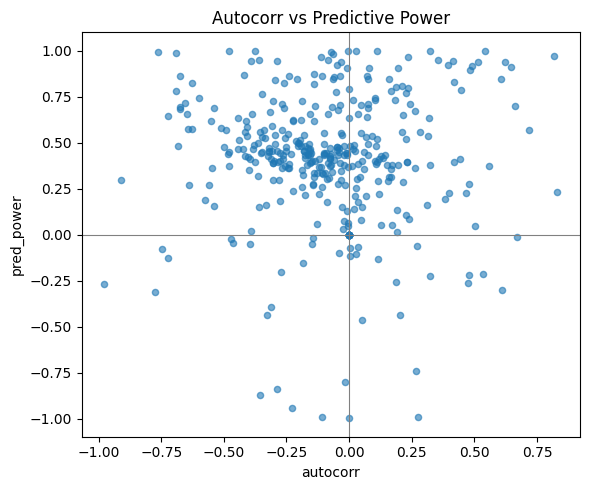

In [299]:
plt.figure(figsize=(6, 5))
plt.scatter(metrics['autocorr'], metrics['pred_power'], s=20, alpha=0.6)
plt.title('Autocorr vs Predictive Power')
plt.xlabel('autocorr')
plt.ylabel('pred_power')
plt.axhline(0, color='gray', linewidth=0.8)
plt.axvline(0, color='gray', linewidth=0.8)
plt.tight_layout()


## Momentum persistence vs mean reversion
We test whether recent momentum persists (trend-following) or mean-reverts by looking at return autocorrelation and conditional probabilities.


In [300]:
def momentum_persistence(prices, lag=1):
    if len(prices) <= lag + 1:
        return np.nan, np.nan, np.nan
    returns = np.diff(prices)
    if np.std(returns) == 0:
        return 0.0, 0.5, 0.5
    autocorr = np.corrcoef(returns[:-lag], returns[lag:])[0, 1]
    prev = returns[:-1]
    nxt = returns[1:]
    mask_pos = prev >= 0
    mask_neg = prev < 0
    p_up_pos = np.mean(nxt[mask_pos] > 0) if np.any(mask_pos) else np.nan
    p_up_neg = np.mean(nxt[mask_neg] > 0) if np.any(mask_neg) else np.nan
    return autocorr, p_up_pos, p_up_neg

p_rows = []
for token_id, g in prices_df.groupby('token_id'):
    g = g.sort_values('timestamp')
    prices = g['price'].to_numpy()
    if len(prices) < MIN_POINTS:
        continue
    ac1, p_up_pos, p_up_neg = momentum_persistence(prices, lag=1)
    p_rows.append({
        'token_id': token_id,
        'conditionId': g['conditionId'].iloc[0],
        'market_id': g['market_id'].iloc[0],
        'autocorr_lag1': ac1,
        'p_up_given_pos_mom': p_up_pos,
        'p_up_given_neg_mom': p_up_neg,
    })

persistence_df = pd.DataFrame(p_rows)
persistence_df.head()


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


,token_id,conditionId,market_id,autocorr_lag1,p_up_given_pos_mom,p_up_given_neg_mom
0,1000020818850347647642138982815862649491064470...,0x92f5d3c973225f097d4ed6a3416fb4dd6e6b28f2a0ee...,573261,-0.039893,0.296296,0.409091
1,1000408696515732713314844979522457272267766060...,0x07094b57090c2c10fd47fed6a9f7f18b7692fd617b90...,548874,-0.181457,0.312500,0.666667
2,1003364619577675634390461213449721484917439262...,0x0a6073ae63c651f666d1596c160582d8139d75904c4e...,583231,NaN,0.000000,NaN
3,1004281994946283372952593213240460956568379878...,0xdb4c9be8df4f83ccfce2c59e6aa17357324a0bead6b4...,596148,0.172831,0.187500,0.400000
4,1005894740092472785494414890184153172024685323...,0x00cba2a437e0cb3c5d3fca0c4bf920104efca53e2382...,616761,0.046610,0.200000,0.428571


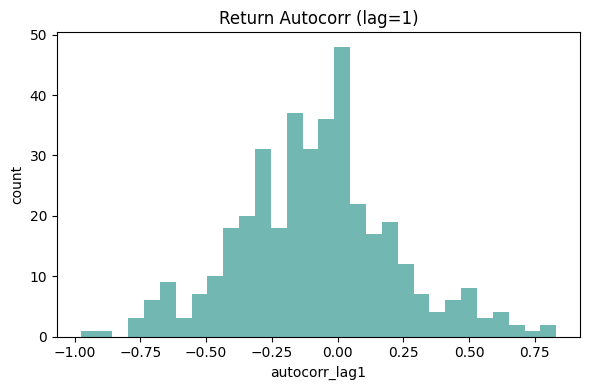

In [301]:
plt.figure(figsize=(6, 4))
plt.hist(persistence_df['autocorr_lag1'].dropna(), bins=30, color='#72b7b2')
plt.title('Return Autocorr (lag=1)')
plt.xlabel('autocorr_lag1')
plt.ylabel('count')
plt.tight_layout()


In [302]:
persistence_df[['p_up_given_pos_mom', 'p_up_given_neg_mom']].describe().transpose()


,count,mean,std,min,25%,50%,75%,max
p_up_given_pos_mom,392.0,0.264423,0.198778,0.0,0.111111,0.240085,0.4,1.0
p_up_given_neg_mom,385.0,0.384717,0.234492,0.0,0.235294,0.375000,0.5,1.0


In [303]:
persistence_df[['p_up_given_pos_mom', 'p_up_given_neg_mom', 'autocorr_lag1']].notna().mean()


p_up_given_pos_mom    1.000000
p_up_given_neg_mom    0.982143
autocorr_lag1         0.984694
dtype: float64

Interpretation:
- If `autocorr_lag1` is mostly positive and `p_up_given_pos_mom` > `p_up_given_neg_mom`, momentum tends to persist.
- If `autocorr_lag1` is mostly negative and `p_up_given_pos_mom` < `p_up_given_neg_mom`, momentum tends to mean-revert.


In [306]:
# save outputs for reuse
OUT_DIR = Path()
OUT_DIR.mkdir(parents=True, exist_ok=True)
metrics_path = OUT_DIR / 'momentum_metrics.csv'
metrics.to_csv(metrics_path, index=False)
print('Wrote', metrics_path)
if 'persistence_df' in globals():
    persistence_path = OUT_DIR / 'momentum_persistence.csv'
    persistence_df.to_csv(persistence_path, index=False)
    print('Wrote', persistence_path)


Wrote momentum_metrics.csv
Wrote momentum_persistence.csv


## Summary tables
These tables are token-level. If you want market-level rollups, we can aggregate by `conditionId`.


In [305]:
metrics.describe(include='all').transpose().head(20)


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
token_id,392,392,1000020818850347647642138982815862649491064470...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
conditionId,392,392,0x92f5d3c973225f097d4ed6a3416fb4dd6e6b28f2a0ee...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
market_id,392,392,573261,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
points,392.0,NaN,NaN,NaN,75.762755,127.218572,8.0,12.0,16.0,56.0,738.0
mean_entropy,392.0,NaN,NaN,NaN,0.390881,0.232589,0.00552,0.159571,0.422544,0.61683,0.693147
flip_count,392.0,NaN,NaN,NaN,0.793367,2.338526,0.0,0.0,0.0,1.0,26.0
velocity,392.0,NaN,NaN,NaN,0.030556,0.034803,0.0,0.002107,0.017295,0.050843,0.178708
early_pnl_proxy,392.0,NaN,NaN,NaN,0.204599,0.211687,0.0,0.027849,0.13885,0.33,0.977429
late_pnl_proxy,392.0,NaN,NaN,NaN,0.020384,0.074494,0.0,0.0,0.0,0.003186,0.6749
autocorr,386.0,NaN,NaN,NaN,-0.08331,0.298073,-0.97679,-0.275578,-0.074605,0.073247,0.831421
